## What I did here 
1. set working directory
2. save all necessary files in WD (Daegu map, occurrence map, Landsat band data ....)
3. calculate NDVI from Landsat national data
4. extract the NDVI at occurrence location 
5.  Check occurrence count ( threshold more than 30: some researcher suggest 25 for for logistic regression )
6.  call logistic regression model
7. fit the occurrence with NDVI (we have just 38 data points may under fit)
8. predict national occurrence map with NDVI 
9. crop for Daegu area 
10. Save raster data 

repeat for random presence absence data  from 4 to 10;
repeat for random presence absence data from 4 to 10, splitting train test data and .piloting ROC curve;
A simple logistic regression code 

In [1]:
import os

# Change the working directory
os.chdir('C:/Users/IT/Downloads/2023')

# Verify the current working directory
print("Current working directory:", os.getcwd())


Current working directory: C:\Users\IT\Downloads\2023


In [2]:
# ls

In [3]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from rasterio import features

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_6608\4145319802.py:15: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


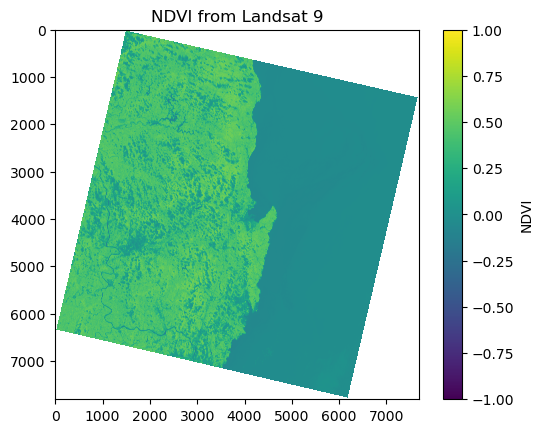

In [4]:
# Paths to the Landsat 9 NIR (Band 5) and Red (Band 4) bands
nir_band_path = 'LC09_L1TP_114035_20230805_20230805_02_T1_B5.TIF'
red_band_path = 'LC09_L1TP_114035_20230805_20230805_02_T1_B4.TIF'

# Open the NIR band (Band 5)
with rio.open(nir_band_path) as nir_src:
    nir = nir_src.read(1).astype('float32')
    nir_meta = nir_src.meta

# Open the Red band (Band 4)
with rio.open(red_band_path) as red_src:
    red = red_src.read(1).astype('float32')

# Calculate NDVI
ndvi = (nir - red) / (nir + red)

# Update metadata to reflect the number of layers
ndvi_meta = nir_meta
ndvi_meta.update({"count": 1})

# # Save the NDVI image
# ndvi_path = 'NDVI.TIF' # we will use this data to crop for daegu are too 
# with rio.open(ndvi_path, 'w', **ndvi_meta) as dst:
#     dst.write(ndvi, 1)

# Plot NDVI
plt.imshow(ndvi, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI from Landsat 9')
plt.show()

In [5]:
nir_meta['crs']

CRS.from_epsg(32652)

In [6]:
#Load the Shapefile and Extract NDVI Values

import geopandas as gpd
from shapely.geometry import Point

# Path to the shapefile containing examined points
shapefile_path = 'Daegu_point_korea_127/Daegu_point_korea_127.dbf'

# Read the shapefile using GeoPandas
gdf_points = gpd.read_file(shapefile_path)

# Reproject points to match the NDVI image CRS if necessary
gdf_points = gdf_points.to_crs(nir_meta['crs'])   

# Extract NDVI values at examined points
ndvi_values = []
for point in gdf_points.geometry:
    row, col = ~nir_meta['transform'] * (point.x, point.y)
    row, col = int(row), int(col)
    if 0 <= row < ndvi.shape[0] and 0 <= col < ndvi.shape[1]:
        ndvi_values.append(ndvi[row, col])
    else:
        ndvi_values.append(np.nan)

# Add NDVI values to GeoDataFrame
gdf_points['ndvi'] = ndvi_values

# # Print examined data points with their NDVI values
# print(gdf_points)
# gdf_points.plot()


In [7]:
# we have data in pandas data frame we can fit different models setting predictor and responses 
gdf_points.head(3)



,Field1,POINT_X,POINT_Y,X_WGS84,Y_WGS84,M__flavigu,N__caudatu,P__bengale,P__volans,geometry,ndvi
0,4046,353396.28562,379854.93607,128.701,36.0042,0,0,1,0,POINT (473053.232 3984455.627),0.483175
1,4060,345197.36726,377639.86725,128.610,35.9855,0,0,1,0,POINT (464843.709 3982410.498),0.432363
2,4087,349679.54327,375371.57778,128.659,35.9644,0,0,1,0,POINT (469252.617 3980053.640),-0.036638


In [8]:
#simply check the occurrences frequency
#normally need more than 30 points

sum(gdf_points['P__bengale']),sum(gdf_points['P__volans']),sum(gdf_points['N__caudatu'])

(38, 1, 0)

In [9]:
# we found there is only oe species that cross the thrreshold 
#o we use P__bengale data
# Prepare data for logistic regression
X = gdf_points[['ndvi']].dropna()  # Predictor
y = gdf_points['P__bengale'][gdf_points['ndvi'].notna()]  # Response
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


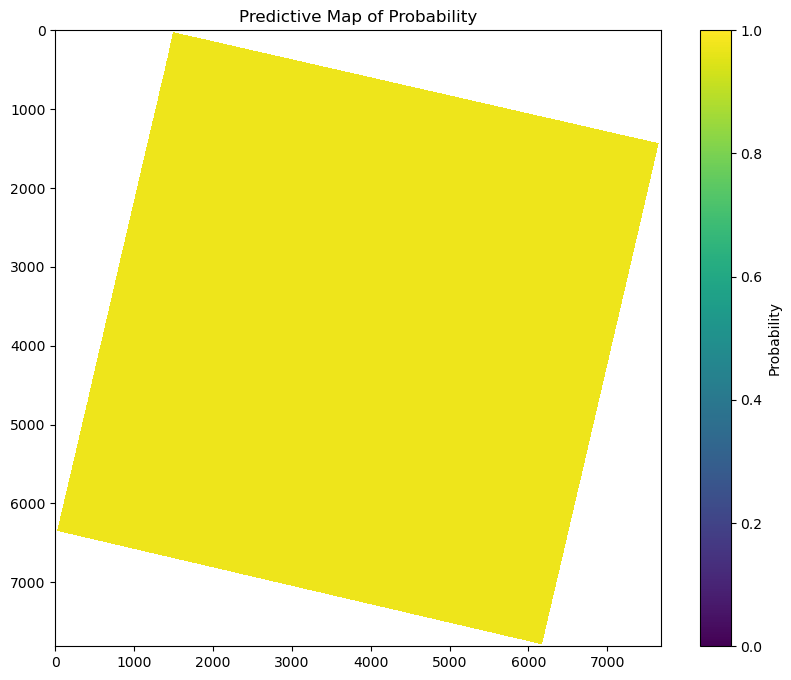

In [10]:
# Predict probabilities over the entire area
ndvi_flat = ndvi.flatten()
ndvi_flat = ndvi_flat[~np.isnan(ndvi_flat)]  # Drop NaN values if any
probs = model.predict_proba(ndvi_flat.reshape(-1, 1))[:, 1]
# Reshape probabilities to match the NDVI shape
prob_map = np.full_like(ndvi, fill_value=np.nan)
prob_map.ravel()[~np.isnan(ndvi.ravel())] = probs
# Plot probability map
plt.figure(figsize=(10, 8))
plt.imshow(prob_map, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label='Probability')
plt.title('Predictive Map of Probability')
plt.show()

In [11]:
# we see there are only presence data so if there is ndvi value, the is high probability 
#Let's make some absance area and fit again 

In [12]:
import random
gdf_points['P_A_species']= [random.randint(0, 1) for _ in range(gdf_points.shape[0])]  # presence absance data 
sum(gdf_points['P_A_species'])

19

In [13]:
X = gdf_points[['ndvi']].dropna()  # Predictor
y = gdf_points['P_A_species'][gdf_points['ndvi'].notna()]  # Response
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


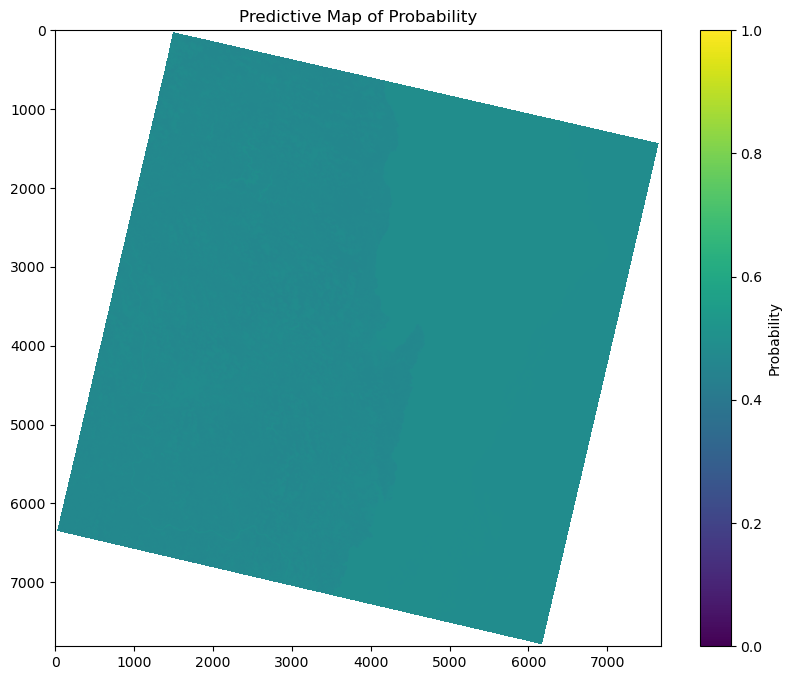

In [14]:
# Predict probabilities over the entire area
ndvi_flat = ndvi.flatten()
ndvi_flat = ndvi_flat[~np.isnan(ndvi_flat)]  # Drop NaN values if any
probs = model.predict_proba(ndvi_flat.reshape(-1, 1))[:, 1]
# Reshape probabilities to match the NDVI shape
prob_map = np.full_like(ndvi, fill_value=np.nan)
prob_map.ravel()[~np.isnan(ndvi.ravel())] = probs
# Plot probability map
plt.figure(figsize=(10, 8))
plt.imshow(prob_map, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label='Probability')
plt.title('Predictive Map of Probability')
plt.show()

In [15]:
#  let's crop Daegu area

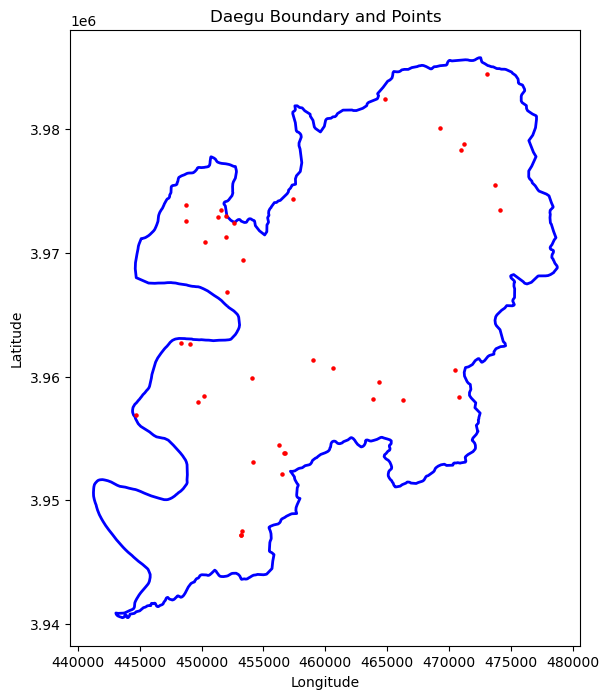

In [16]:
# Load Daegu boundary shapefile (replace with  actual file path)
daegu_boundary = gpd.read_file("Daegu/Daegu.dbf").to_crs(nir_meta['crs']) 
# Plotting the boundary of Daegu
fig, ax = plt.subplots(figsize=(10, 8))  # Optional: Adjust figure size
daegu_boundary.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)

# Plotting the points on the same plot
gdf_points.plot(ax=ax, color='red', markersize=5)

# Adding titles and labels
ax.set_title('Daegu Boundary and Points')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Display the plot
plt.show()

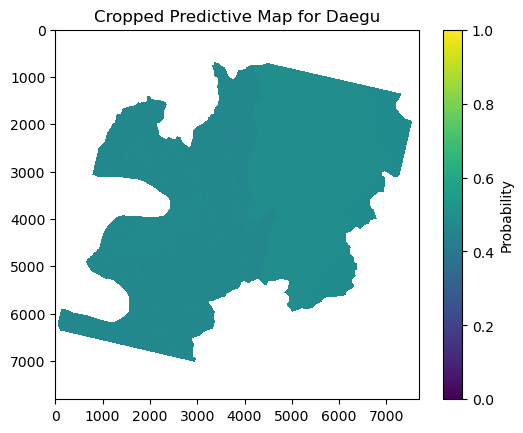

In [17]:
# Rasterize the cropped Daegu boundary to use it as a mask
daegu_mask = features.rasterize(
    [(geom, 1) for geom in daegu_boundary.geometry],
    out_shape=prob_map.shape,
    transform=rio.transform.from_bounds(*daegu_boundary.total_bounds, prob_map.shape[1], prob_map.shape[0]),
    fill=0,
    all_touched=True,
    dtype=np.int16,
)

# Apply the mask to prob_map (exclude zero values)
prob_map_cropped = prob_map.copy()
prob_map_cropped[daegu_mask == 0] = np.nan

# Plot the cropped probability map
plt.imshow(prob_map_cropped, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label='Probability')
plt.title('Cropped Predictive Map for Daegu')
plt.show()

# Save the cropped probability map as a raster file
output_file = 'cropped_prob1_map.tif'
with rio.open(output_file, 'w', driver='GTiff', width=prob_map_cropped.shape[1], height=prob_map_cropped.shape[0], count=1, dtype=rio.float64, crs=rio.crs.CRS.from_epsg(4326), transform=rio.transform.from_bounds(*daegu_boundary.total_bounds, prob_map_cropped.shape[1], prob_map_cropped.shape[0])) as dst:
    dst.write(prob_map_cropped, 1)

In [18]:
# let's check with test train data and ROC curve

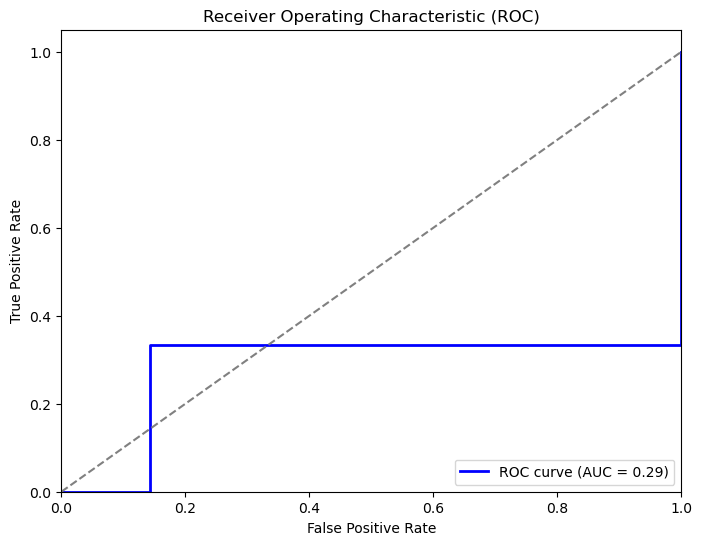

In [19]:
# we found there is only oe species that cross the thrreshold 
#o we use P__bengale data
# Prepare data for logistic regression
X = gdf_points[['ndvi']].dropna()  # Predictor
y = gdf_points['P_A_species'][gdf_points['ndvi'].notna()]  # Response
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)
# Fit logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)
# Predict probabilities on test set
y_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


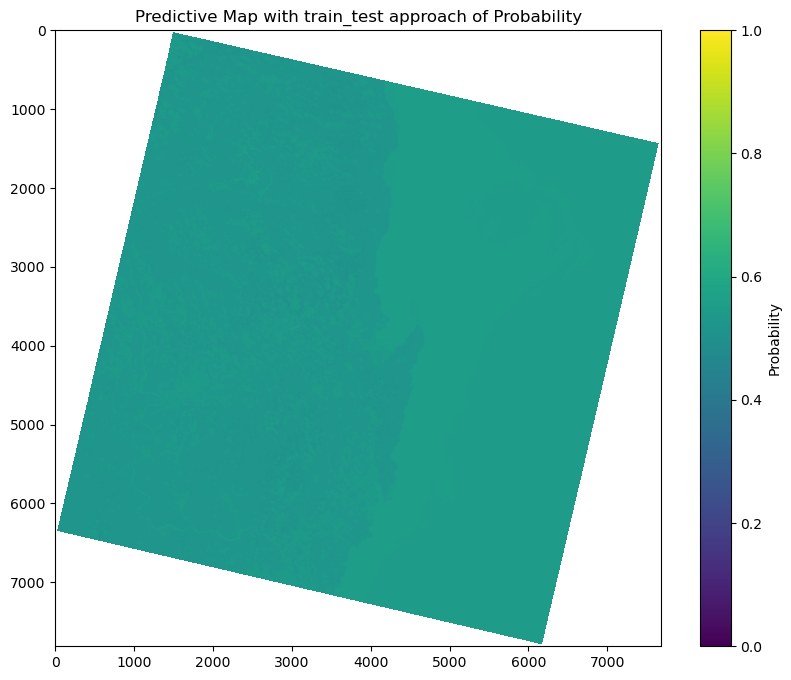

In [20]:
# Predict probabilities over the entire area
ndvi_flat = ndvi.flatten()
ndvi_flat = ndvi_flat[~np.isnan(ndvi_flat)]  # Drop NaN values if any
probs = model.predict_proba(ndvi_flat.reshape(-1, 1))[:, 1]
# Reshape probabilities to match the NDVI shape
prob_map = np.full_like(ndvi, fill_value=np.nan)
prob_map.ravel()[~np.isnan(ndvi.ravel())] = probs
# Plot probability map
plt.figure(figsize=(10, 8))
plt.imshow(prob_map, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label='Probability')
plt.title('Predictive Map with train_test approach of Probability')
plt.show()

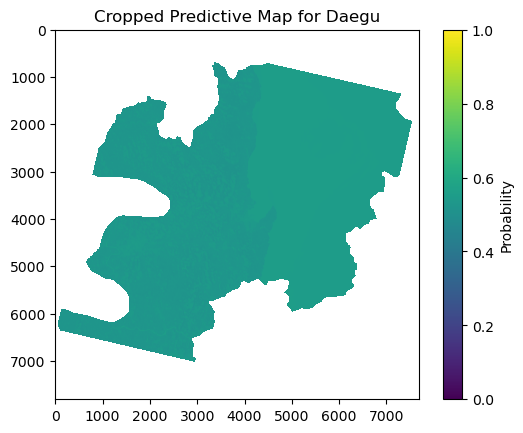

In [21]:
# Rasterize the cropped Daegu boundary to use it as a mask
daegu_mask = features.rasterize(
    [(geom, 1) for geom in daegu_boundary.geometry],
    out_shape=prob_map.shape,
    transform=rio.transform.from_bounds(*daegu_boundary.total_bounds, prob_map.shape[1], prob_map.shape[0]),
    fill=0,
    all_touched=True,
    dtype=np.int16,
)

# Apply the mask to prob_map (exclude zero values)
prob_map_cropped = prob_map.copy()
prob_map_cropped[daegu_mask == 0] = np.nan

# Plot the cropped probability map
plt.imshow(prob_map_cropped, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label='Probability')
plt.title('Cropped Predictive Map for Daegu')
plt.show()

# Save the cropped probability map as a raster file
output_file = 'cropped_prob1_map.tif'
with rio.open(output_file, 'w', driver='GTiff', width=prob_map_cropped.shape[1], height=prob_map_cropped.shape[0], count=1, dtype=rio.float64, crs=rio.crs.CRS.from_epsg(4326), transform=rio.transform.from_bounds(*daegu_boundary.total_bounds, prob_map_cropped.shape[1], prob_map_cropped.shape[0])) as dst:
    dst.write(prob_map_cropped, 1)

Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       106
           1       0.99      1.00      0.99        94

    accuracy                           0.99       200
   macro avg       0.99      1.00      0.99       200
weighted avg       1.00      0.99      1.00       200


Confusion Matrix:
[[105   1]
 [  0  94]]


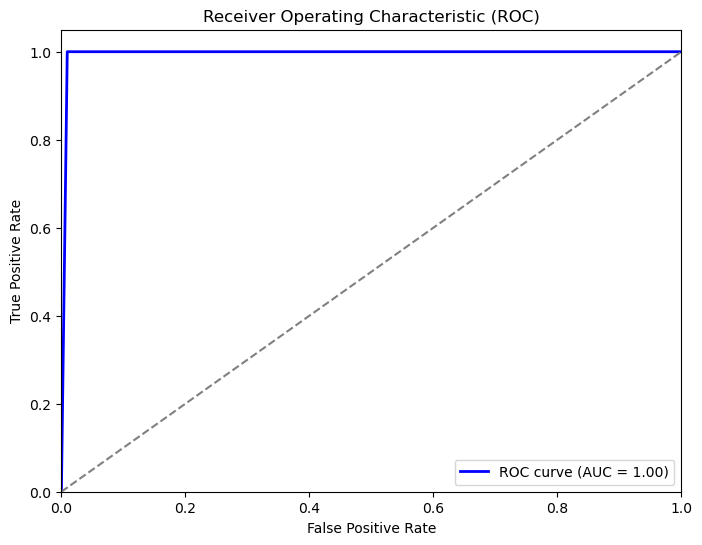

In [24]:
# A simple logistic regression code 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Generate random variables (features) and labels
np.random.seed(42)
X = np.random.rand(1000, 2)  # Example features (random variables)
y = (X.sum(axis=1) > 1.0).astype(int)  # Example labels based on a condition

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize logistic regression model
model = LogisticRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
